## Предсказание пола/возраста по посещениям сайтов

Для начала, подключим хранилище s3, содержащее исходные данные:

Убедимся, что в директории `mnt` содержатся соответствующие таблицы:

Если по каким-то причинам директорию смонтировать не удалось, используйте код ниже, чтобы скачать данные к себе в локальное хранилище. В противном случае **пропустите следующую ячейку**.

## Загружаем данные

Используем Pandas для работы с таблицами. `geo_dataframe` содержит данные о геолокации - регионе и стране.

In [1]:
import pandas as pd

geo = pd.read_csv('geo_dataframe.csv')
geo

,geo_id,region_id,country_id
0,1,157,40
1,2,161,40
2,3,265,54
3,4,122,54
4,5,78,40
...,...,...,...
5528,5529,246,54
5529,5530,-1,63
5530,5531,101,40
5531,5532,21,68


Таблица `train_users` - это ваша обучающая выборка, содержащая пол и возраст пользователей. Аналогичная таблица для тестового датасета будет вам предоставлена за час до stop coding.

In [2]:
users = pd.read_csv('train_users.csv')
users

,user_id,gender,age
0,2,1,61
1,3,1,55
2,6,0,46
3,14,0,66
4,17,0,53
...,...,...,...
4999995,17588859,1,64
4999996,17588860,0,69
4999997,17588861,1,51
4999998,17588864,0,30


Для примера - вот распределение пользователей по полу:

<Axes: xlabel='gender'>

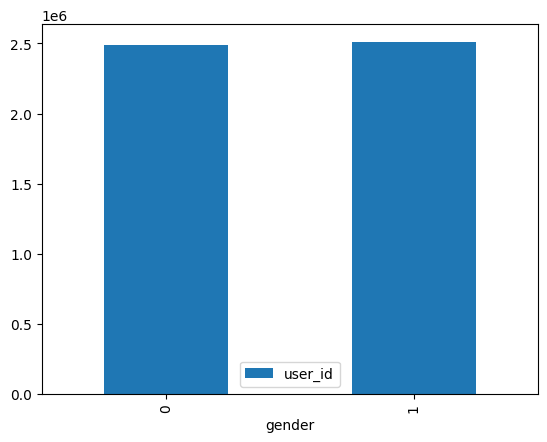

In [3]:
import matplotlib.pyplot as plt
users.groupby('gender').agg({ 'user_id' : len }).plot.bar()

Основные данные о посещениях пользователями сайтов содержатся в табличке `requests`, представленной в формате parquet. Вы можете загрузить только одну часть таблички, или же всю таблицу, если она поместиться в памяти:

In [5]:
name = 'part_0'
req = pd.read_parquet('req1.parquet')
req

,timestamp,geo_id,referer,user_id,user_agent
0,1712169477,1224,https://www.domain_1118/path_107938,1628092,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
1,1711945301,2540,https://domain_3207/path_175610,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...
2,1712154596,4402,https://domain_2194/path_172150,8274161,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
3,1711941903,3833,https://domain_2042/path_144480,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,1712088484,3866,https://domain_3191/path_9105,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
...,...,...,...,...,...
10000449,1712161101,702,https://domain_662/path_131980,2062442,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
10000450,1711940706,3515,https://domain_1784/path_45033,2375719,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
10000451,1712107755,3173,https://domain_1654/path_48166,11781572,Mozilla/5.0 (Linux; arm_64; Android 13; SM-A14...
10000452,1712107427,3833,https://domain_1654/path_10504,15183751,Mozilla/5.0 (Linux; arm_64; Android 12; SM-M21...


In [28]:
merged = pd.merge(req, users, on='user_id', how='left')
merged = merged[pd.notna(merged.gender) | pd.notna(merged.age)]
merged = pd.merge(merged, geo, on='geo_id', how='left')
merged = merged.head(500000)
merged

,timestamp,geo_id,referer,user_id,user_agent,gender,age,region_id,country_id
0,1711945301,2540,https://domain_3207/path_175610,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,1.0,75.0,135,199
1,1711941903,3833,https://domain_2042/path_144480,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0.0,72.0,78,40
2,1712088484,3866,https://domain_3191/path_9105,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1.0,73.0,-1,79
3,1711918808,1840,https://domain_551/path_175610,8871292,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,0.0,18.0,192,40
4,1712117806,2293,https://domain_662/path_120157,11372673,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1.0,41.0,184,40
...,...,...,...,...,...,...,...,...,...
499995,1712139644,3948,https://www.domain_294/path_146930,12714094,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1.0,69.0,189,40
499996,1712130188,2540,https://domain_2238/path_142190,11110004,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1.0,72.0,135,199
499997,1712144776,624,https://domain_1654/path_121641,5916185,Mozilla/5.0 (Linux; arm_64; Android 10; Redmi ...,1.0,74.0,49,40
499998,1711946661,3173,https://domain_2833/path_138343,921657,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,1.0,41.0,184,40


## Дерзайте!

Вам необходимо построить предсказательную модель для прогнозирования пола и возраста пользователей по их посещениям. Таблица с тестовыми пользователями будет предоставлена вам за час до stop coding.

ВАЖНО:
* Таблицу с тестовыми данными нельзя использовать для обучения модели. Если жюри увидит, что вы использовали табличку с тестовыми данными - точность модели будет оцениваться в 0 баллов.
* В ходе выступления необходимо продемонстрировать точность модели на тестовых данных.

In [29]:
from tqdm.auto import tqdm
import ua_parser.user_agent_parser

def parse_user_agent(user_agent_string):
    parsed_ua = ua_parser.user_agent_parser.Parse(user_agent_string)
    return parsed_ua['user_agent']['family'], parsed_ua['os']['family'], parsed_ua['device']['family']


In [67]:
domains = []
paths = []
browsers = []
oses = []
devices = []

for i, row in tqdm(merged.iterrows()):
    r = row["referer"]
    if r:
        domains.append(r[r.index("domain") + 7: r.rfind("/")])
        paths.append(r[r.index("path") + 5:])
    else:
        domains.append('')
        paths.append('')

    browser, os, device = parse_user_agent(row["user_agent"])
    browsers.append(browser)
    oses.append(os)
    devices.append(device)


0it [00:00, ?it/s]

In [68]:
merged['domain'] = domains
merged['path'] = paths
merged['browser'] = browsers
merged['os'] = oses
merged['devices'] = devices
merged

,timestamp,geo_id,referer,user_id,user_agent,domain,path,browser,os,devices,gender,age
0,1711945301,2540,https://domain_3207/path_175610,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,3207,175610,Opera Mobile,Android,XiaoMi Redmi 5 Plus,1,75
1,1711941903,3833,https://domain_2042/path_144480,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2042,144480,Chrome,Windows,Other,0,72
2,1712088484,3866,https://domain_3191/path_9105,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,3191,9105,Chrome,Windows,Other,1,73
3,1711918808,1840,https://domain_551/path_175610,8871292,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,551,175610,Chrome Mobile,Android,K,0,18
4,1712117806,2293,https://domain_662/path_120157,11372673,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,662,120157,Chrome,Windows,Other,1,41
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1712139644,3948,https://www.domain_294/path_146930,12714094,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,294,146930,Opera,Windows,Other,1,69
499996,1712130188,2540,https://domain_2238/path_142190,11110004,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2238,142190,Chrome,Windows,Other,1,72
499997,1712144776,624,https://domain_1654/path_121641,5916185,Mozilla/5.0 (Linux; arm_64; Android 10; Redmi ...,1654,121641,Chrome,Android,XiaoMi Redmi Note 7,1,74
499998,1711946661,3173,https://domain_2833/path_138343,921657,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,2833,138343,Chrome Mobile,Android,K,1,41


In [75]:
merged_final = pd.merge(merged, users, on='user_id', how='left')
merged_final = merged[pd.notna(merged['gender']) | pd.notna(merged['age'])]
merged_final = pd.merge(merged, geo, on='geo_id', how='left')
merged_final

,timestamp,geo_id,referer,user_id,user_agent,domain,path,browser,os,devices,gender,age,region_id,country_id
0,1711945301,2540,https://domain_3207/path_175610,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,3207,175610,Opera Mobile,Android,XiaoMi Redmi 5 Plus,1,75,135,199
1,1711941903,3833,https://domain_2042/path_144480,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2042,144480,Chrome,Windows,Other,0,72,78,40
2,1712088484,3866,https://domain_3191/path_9105,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,3191,9105,Chrome,Windows,Other,1,73,-1,79
3,1711918808,1840,https://domain_551/path_175610,8871292,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,551,175610,Chrome Mobile,Android,K,0,18,192,40
4,1712117806,2293,https://domain_662/path_120157,11372673,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,662,120157,Chrome,Windows,Other,1,41,184,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1712139644,3948,https://www.domain_294/path_146930,12714094,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,294,146930,Opera,Windows,Other,1,69,189,40
499996,1712130188,2540,https://domain_2238/path_142190,11110004,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2238,142190,Chrome,Windows,Other,1,72,135,199
499997,1712144776,624,https://domain_1654/path_121641,5916185,Mozilla/5.0 (Linux; arm_64; Android 10; Redmi ...,1654,121641,Chrome,Android,XiaoMi Redmi Note 7,1,74,49,40
499998,1711946661,3173,https://domain_2833/path_138343,921657,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,2833,138343,Chrome Mobile,Android,K,1,41,184,40


In [87]:
filtered = merged_final.drop(['referer','geo_id'], axis=1)
filtered

,timestamp,user_id,user_agent,domain,path,browser,os,devices,gender,age,region_id,country_id
0,1711945301,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,3207,175610,Opera Mobile,Android,XiaoMi Redmi 5 Plus,1,75,135,199
1,1711941903,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2042,144480,Chrome,Windows,Other,0,72,78,40
2,1712088484,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,3191,9105,Chrome,Windows,Other,1,73,-1,79
3,1711918808,8871292,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,551,175610,Chrome Mobile,Android,K,0,18,192,40
4,1712117806,11372673,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,662,120157,Chrome,Windows,Other,1,41,184,40
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1712139644,12714094,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,294,146930,Opera,Windows,Other,1,69,189,40
499996,1712130188,11110004,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2238,142190,Chrome,Windows,Other,1,72,135,199
499997,1712144776,5916185,Mozilla/5.0 (Linux; arm_64; Android 10; Redmi ...,1654,121641,Chrome,Android,XiaoMi Redmi Note 7,1,74,49,40
499998,1711946661,921657,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,2833,138343,Chrome Mobile,Android,K,1,41,184,40


In [88]:
filtered = filtered[filtered['domain'].str.strip().astype(bool)]
filtered

,timestamp,user_id,user_agent,domain,path,browser,os,devices,gender,age,region_id,country_id
0,1711945301,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,3207,175610,Opera Mobile,Android,XiaoMi Redmi 5 Plus,1,75,135,199
1,1711941903,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2042,144480,Chrome,Windows,Other,0,72,78,40
2,1712088484,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,3191,9105,Chrome,Windows,Other,1,73,-1,79
3,1711918808,8871292,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,551,175610,Chrome Mobile,Android,K,0,18,192,40
4,1712117806,11372673,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,662,120157,Chrome,Windows,Other,1,41,184,40
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1712139644,12714094,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,294,146930,Opera,Windows,Other,1,69,189,40
499996,1712130188,11110004,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2238,142190,Chrome,Windows,Other,1,72,135,199
499997,1712144776,5916185,Mozilla/5.0 (Linux; arm_64; Android 10; Redmi ...,1654,121641,Chrome,Android,XiaoMi Redmi Note 7,1,74,49,40
499998,1711946661,921657,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,2833,138343,Chrome Mobile,Android,K,1,41,184,40


In [89]:
filtered['path_count'] = filtered.groupby(['user_id', 'domain'])['path'].transform('size')
filtered

C:\Users\Gregory\AppData\Local\Temp\ipykernel_31916\3616112996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['path_count'] = filtered.groupby(['user_id', 'domain'])['path'].transform('size')


,timestamp,user_id,user_agent,domain,path,browser,os,devices,gender,age,region_id,country_id,path_count
0,1711945301,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,3207,175610,Opera Mobile,Android,XiaoMi Redmi 5 Plus,1,75,135,199,1
1,1711941903,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2042,144480,Chrome,Windows,Other,0,72,78,40,1
2,1712088484,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,3191,9105,Chrome,Windows,Other,1,73,-1,79,1
3,1711918808,8871292,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,551,175610,Chrome Mobile,Android,K,0,18,192,40,2
4,1712117806,11372673,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,662,120157,Chrome,Windows,Other,1,41,184,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1712139644,12714094,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,294,146930,Opera,Windows,Other,1,69,189,40,1
499996,1712130188,11110004,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2238,142190,Chrome,Windows,Other,1,72,135,199,1
499997,1712144776,5916185,Mozilla/5.0 (Linux; arm_64; Android 10; Redmi ...,1654,121641,Chrome,Android,XiaoMi Redmi Note 7,1,74,49,40,1
499998,1711946661,921657,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,2833,138343,Chrome Mobile,Android,K,1,41,184,40,1


In [96]:
from sklearn.preprocessing import LabelEncoder

label_encoder_browser = LabelEncoder()
filtered['browser'] = label_encoder_browser.fit_transform(filtered['browser'])

label_encoder_os = LabelEncoder()
filtered['os'] = label_encoder_os.fit_transform(filtered['os'])

label_encoder_device = LabelEncoder()
filtered['devices'] = label_encoder_device.fit_transform(filtered['devices'])

label_encoder_domain = LabelEncoder()
filtered['domain'] = label_encoder_device.fit_transform(filtered['domain'])

label_encoder_path = LabelEncoder()
filtered['path'] = label_encoder_device.fit_transform(filtered['path'])

# Полученные значения могут быть сохранены, чтобы использовать их для обратного преобразования, если это необходимо:
# inverse_browser = label_encoder_browser.inverse_transform(filtered['browser_code'])

filtered

C:\Users\Gregory\AppData\Local\Temp\ipykernel_31916\2887933479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['browser'] = label_encoder_browser.fit_transform(filtered['browser'])
C:\Users\Gregory\AppData\Local\Temp\ipykernel_31916\2887933479.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['os'] = label_encoder_os.fit_transform(filtered['os'])
C:\Users\Gregory\AppData\Local\Temp\ipykernel_31916\2887933479.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,timestamp,user_id,user_agent,domain,path,browser,os,devices,gender,age,region_id,country_id,path_count
0,1711945301,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...,755,5808,26,0,2477,1,75,135,199,1
1,1711941903,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,382,3406,2,8,1509,0,72,78,40,1
2,1712088484,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,748,13150,2,8,1509,1,73,-1,79,1
3,1711918808,8871292,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,883,5808,3,0,874,0,18,192,40,2
4,1712117806,11372673,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,918,1552,2,8,1509,1,41,184,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1712139644,12714094,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,667,3599,24,8,1509,1,69,189,40,1
499996,1712130188,11110004,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,452,3239,2,8,1509,1,72,135,199,1
499997,1712144776,5916185,Mozilla/5.0 (Linux; arm_64; Android 10; Redmi ...,235,1674,2,0,2519,1,74,49,40,1
499998,1711946661,921657,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,635,2964,3,0,874,1,41,184,40,1


In [99]:
import pandas as pd
from sklearn.utils import resample

# Предположим, что df - это ваш DataFrame, а 'gender' - столбец с категориальными данными (0 и 1)
# Определяем, какие строки содержат 0, а какие - 1
zeros = filtered[filtered['gender'] == 0]
ones = filtered[filtered['gender'] == 1]

# Находим количество элементов в каждом из классов
zeros_count = len(zeros)
ones_count = len(ones)

# Определяем, какой класс имеет больше элементов
majority_class = 0 if zeros_count > ones_count else 1
minority_class = 1 if majority_class == 0 else 0

# Уменьшаем выборку для большего класса
downsampled_majority = resample(zeros if majority_class == 0 else ones,
                                replace=False,  # Не заменяем элементы
                                n_samples=ones_count if majority_class == 1 else zeros_count,  # Количество элементов равно количеству элементов в меньшем классе
                                random_state=42)  # Для воспроизводимости

# Создаем новый DataFrame с уменьшенной выборкой
downsampled_df = pd.concat([downsampled_majority, ones if majority_class == 0 else zeros])


In [ ]:
import pandas as pd
import numpy as np
import fasttext
from sklearn.manifold import TSNE
import plotly.graph_objs as go

# Normalize UAS to lower case, add labels, and split data into train and test sets
np.random.seed(42)
filtered['user_agent'] = filtered['user_agent'].str.lower()
filtered['labeled_uas'] = "__label__" + filtered['os'] + " " + filtered['user_agent']
filtered['dataset'] = np.random.choice(["train", "test"], size=len(filtered), replace=True, p=[0.975, 0.025])

# Write train and test sets into text files, as expected by fastText
filtered[filtered['dataset'] == "train"]['labeled_uas'].to_csv("./data/train_data_sup.txt", index=False, header=False)
filtered[filtered['dataset'] == "test"]['labeled_uas'].to_csv("./data/test_data_sup.txt", index=False, header=False)

test_data = filtered[filtered['dataset'] == "test"]

# Supervised training
params = {
    "input": "./data/train_data_sup.txt",
    "lr": 0.05,
    "dim": 32,
    "minn": 2,
    "maxn": 6,
    "minCount": 1,
    "minCountLabel": 10,
    "neg": 3,
    "wordNgrams": 2,
    "ws": 3,
    "epoch": 100,
    "loss": 'softmax',
    "thread": 12
}

# Train the model
model_sup = fasttext.train_supervised(**params)

# Save the model for further use
model_sup.save_model("./data/model_sup.bin")

# Check precision, recall, and f1 score for individual labels
metrics = model_sup.test_label("./data/test_data_sup.txt")
print(metrics["__label__Windows"])

# Calculate embeddings for each UAS from the test set
emb_sup = [model_sup.get_sentence_vector(text) for text in test_data['labeled_uas']]
emb_sup = pd.DataFrame(emb_sup, columns=[f"f{i+1}" for i in range(params['dim'])])

# Apply tSNE to ease visualization of the resultant embeddings
tsne_sup = TSNE(n_components=3, perplexity=40, n_iter=1000, method='exact', random_state=42)
tsne_coords_sup = tsne_sup.fit_transform(emb_sup)

# Get tSNE coordinates
tsne_coords_sup = pd.DataFrame(tsne_coords_sup, columns=["D1", "D2", "D3"])
tsne_coords_sup['label'] = test_data['os']
tsne_coords_sup = tsne_coords_sup[tsne_coords_sup['label'].isin(["Windows", "Android", "IOS", "Linux", "Mac OS X"])]

# Visualize results in an interactive plot
fig = go.Figure(data=go.Scatter3d(
    x=tsne_coords_sup['D1'],
    y=tsne_coords_sup['D2'],
    z=tsne_coords_sup['D3'],
    mode='markers',
    marker=dict(
        size=4,
        opacity=0.5,
        color=tsne_coords_sup['label'],
        colorscale='Set1'
    ),
    text=tsne_coords_sup['label']
))

fig.update_layout(
    scene=dict(
        xaxis=dict(title='tSNE dimension 1', showspikes=False),
        yaxis=dict(title='tSNE dimension 2', showspikes=False),
        zaxis=dict(title='tSNE dimension 3', showspikes=False)
    ),
    showlegend=True,
    legend=dict(title='<b> Os: </b>'),
    autosize=False,
    margin=dict(l=2, r=2, b=2, t=30, pad=1)
)

fig.show(config={'displayModeBar': False})

In [97]:
features = ['path_count', 'country_id', 'region_id', 'os', 'devices', 'browser', 'domain', 'path']
target_age = ['age']
target_gender = ['gender']

In [100]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_val, y_train, y_val = train_test_split(downsampled_df[features], downsampled_df[target_gender], test_size=0.2, random_state=42)

# Создание модели LightGBM
model = lgb.LGBMClassifier()

# Обучение модели на обучающих данных
model.fit(X_train, y_train)

# Прогнозирование на валидационных данных
predictions = model.predict(X_val)

# Вычисление точности
accuracy = accuracy_score(y_val, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_val, predictions))

C:\Users\Gregory\PycharmProjects\vk_hack_local\venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gregory\PycharmProjects\vk_hack_local\venv\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 200244, number of negative: 182093
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1009
[LightGBM] [Info] Number of data points in the train set: 382337, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523737 -> initscore=0.095019
[LightGBM] [Info] Start training from score 0.095019
Accuracy: 0.6139247789925197

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.41      0.50     45460
           1       0.60      0.80      0.69     50125

    accuracy                           0.61     95585
   macro avg       0.62      0.60      0.59     95585
weighted avg       0.62      0.61      0.60     95585



In [102]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import r2_score

X_train, X_val, y_train, y_val = train_test_split(filtered[features], filtered[target_age], test_size=0.2, random_state=42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_val)

r2 = r2_score(y_val, predictions)
print("R^2 Score:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 382337, number of used features: 8
[LightGBM] [Info] Start training from score 51.036426
R^2 Score: 0.15567370895016752


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Предположим, что filtered[features] содержит ваши признаки
X = filtered[features]
y = filtered[target_age]

# Разделяем данные на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем полиномиальные признаки
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# Создаем и обучаем модель линейной регрессии
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Прогнозирование на тестовой выборке
predictions = model.predict(X_val_poly)

# Вычисляем коэффициент детерминации (R^2)
r2 = r2_score(y_val, predictions)
print("R^2 Score:", r2)

R^2 Score: 0.05026700060475042


In [103]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier

X_age = filtered[features]
y_age = filtered[target_age]
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age, y_age, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_age_train, y_age_train)

y_age_pred = ridge_model.predict(X_age_test)

age_accuracy = ridge_model.score(X_age_test, y_age_test)
print("Accuracy for age:", age_accuracy)

X_gender = filtered[features]
y_gender = filtered[target_gender]
X_gender_train, X_gender_test, y_gender_train, y_gender_test = train_test_split(X_gender, y_gender, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
rf_classifier.fit(X_gender_train, y_gender_train)

y_gender_pred = rf_classifier.predict(X_gender_test)

gender_accuracy = accuracy_score(y_gender_test, y_gender_pred)
print("Accuracy for gender:", gender_accuracy)


Accuracy for age: 0.03501400540289312


C:\Users\Gregory\PycharmProjects\vk_hack_local\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy for gender: 0.6014228173876655


## Убираем за собой

В конце работы можем размонтировать директорию:

In [19]:
!umount mnt

umount: /home/datadisk/jupyter-vkhack/vkhack/gender_prediction/mnt: not mounted.
